In [1]:
# %load imports.ipy
# Stdlib
from functools import partial
from itertools import chain
from pprint import pprint as print

import numpy as np
import pandas as pd

pd.set_option('display.max_columns',102)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width',120)
import sklearn
print(f'numpy {np.__version__} pandas {pd.__version__} sklearn {sklearn.__version__}')

# Visualization

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

custom_style = {'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white', }
sns.set_style( rc=custom_style)
mpl.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.figsize']=(10,10)
jtplot.style('monokai')
# Custom stuff
from swozny_ml import *
from genetic.parameter_optimization import tune_params_genetic


'numpy 1.13.3 pandas 0.20.3 sklearn 0.19.0'


/home/swozny/untitled5/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# %load classify.py
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score

from genetic.estimator_parameters import params
from genetic.parameter_optimization import tune_params_genetic
from swozny_ml import benchmark_models, tune_params

# Config

In [3]:
filename = 'datasets/preprocessed_kobe.csv'
index = 'shot_id'
target = 'shot_made_flag'
prediction_params = ['Angle', 'Distance']
scoring = 'neg_log_loss'
voting = 'soft'

# Read data

In [4]:
data = pd.read_csv(filename, index_col=index)
print(data.head())

         action_type_1  action_type_2  action_type_3  action_type_4  action_type_5  action_type_6  action_type_7  \
shot_id                                                                                                            
1        0              0              0              0              0              0              0               
2        0              0              0              0              0              0              0               
3        0              0              0              0              0              0              0               
4        0              0              0              0              0              0              0               
5        0              0              0              0              0              1              0               

         combined_shot_type_Dunk  combined_shot_type_Hook Shot  combined_shot_type_Jump Shot  \
shot_id                                                                                    

# Prepare data

In [5]:
training_cond = data[target].notnull()
X = data[training_cond].drop(target,axis=1)#[prediction_params]
y = data[training_cond][target]
X_train, X_validation ,y_train,y_validation = sklearn.model_selection.train_test_split(X,y,test_size=0.05)

# Benchmark different estimators

In [13]:
from sklearn.svm import SVC
from functools import partial
from xgboost import XGBClassifier
params={
                      'colsample_bytree': 0.6,
                      'min_child_weight': 5, 
                      'subsample': 0.6, 
                      'learning_rate': 0.03,
#                       'eta': 0.2, 
                      'max_depth': 11, 
                      'gamma': 0.75,
#                       'n_classes': 2,
                      'n_estimators': 350
                      }
print(cross_val_score(XGBClassifier(n_estimators=400),X_train,y_train,scoring=scoring))
print(sm)
classifiers = [LogisticRegression,sm]#,partial(SVC,probability=True)]
# benchmark = benchmark_models(classifiers, X_train, y_train, scoring=scoring)

array([-0.59895449, -0.59982102, -0.59647706])


NameError: name 'sm' is not defined

# Report estimator performances

In [ ]:
plot_benchmark(benchmark)
considered_algorithms = benchmark.sort_values('Mean').tail(2)
print(considered_algorithms)

# Tune the best estimators

In [ ]:
if True:
    tuned = tune_params(classifiers, X_train, y_train, scoring=scoring)
else:
    tuned = tune_params_genetic(considered_algorithms['Algorithm'], X_train, y_train, scoring=scoring)

# Calibrate the tuned estimators

In [ ]:
calibrated = [CalibratedClassifierCV(model).fit(X_train, y_train) for model in tuned]
calibrated

In [ ]:
tuned[-1]

# Show Correlation between estimators

In [ ]:
predictions = pd.concat(
    [pd.Series(model.predict(X_train), name=type(model.base_estimator).__name__) for model in calibrated], axis=1)
sns.heatmap(predictions.corr())

# Create an ensemble

In [ ]:
ensemble_model = VotingClassifier([(type(model.base_estimator).__name__, model) for model in calibrated], voting=voting)

# Predict

In [7]:
ensemble_model=XGBClassifier(**params)
score = cross_val_score(ensemble_model, X=X_validation, y=y_validation,scoring=scoring)
print(f"Final cross validation score is {score}")

'Final cross validation score is [-0.64477483 -0.63629162 -0.6541632 ]'


# Confusion

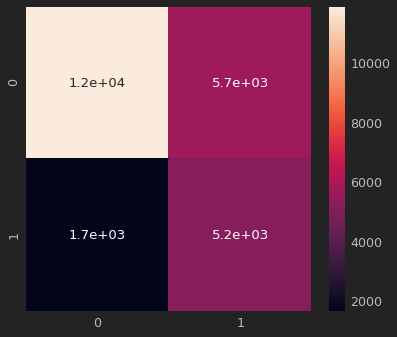

In [8]:
ensemble_model.fit(X_train, y_train)
sns.heatmap(confusion_matrix(ensemble_model.predict(X_train), y_train), annot=True)

# Generate output

In [9]:
test_cond = ~training_cond
X_test = data[test_cond].drop(target,axis=1)#[prediction_params]
y_pred = ensemble_model.predict_proba(X_test)
X_test['shot_made_flag'] = y_pred[:, 1]
X_test.shot_made_flag.to_csv('predictions/kobe.csv', header=True)